# The finite Gaussian Process Distribution of Relaxation Times (fGP-DRT)

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
import finite_GP_DRT
from scipy.optimize import minimize
import importlib
importlib.reload(finite_GP_DRT)
%matplotlib inline

## 1) The single ZARC model with an inductance

The impedance and corresponding DRT of a single ZARC with inductance are given by
$$
Z_{\rm exact}(f) = R_\infty + i2\pi f L_{0} + \displaystyle \frac{R_{\rm ct}}{\displaystyle 1+ \left(i 2\pi f \tau_0\right)^\phi}
$$

$$
\gamma(\log \tau) =  \displaystyle \frac{\displaystyle R_{\rm ct}}{\displaystyle 2\pi} \displaystyle \frac{\displaystyle \sin\left((1-\phi)\pi\right)}{\displaystyle \cosh(\phi \log(\tau/\tau_0))-\cos(\pi(1-\phi))}
$$

### 1.1) Ranges of log frequencies and log timescales

In [94]:
# define the range of log frequencies
log_freq_min = -4.
log_freq_max = 4.

# define the range of log timescales
log_tau_min = -4  
log_tau_max = 4   

# number of collocation points in log(freq) and log(tau)
N_freqs = 10*int(log_freq_max-log_freq_min)+1
N_taus = 10*int(log_tau_max-log_tau_min)+1

# freq and tau vectors
freq_vec = np.logspace(log_freq_min, log_freq_max, num = N_freqs, endpoint=True)
tau_vec = np.logspace(log_tau_min, log_tau_max, num = N_taus, endpoint=True)
log_tau_vec = np.log(tau_vec)

### 1.2) Exact ZARC model

In [95]:
# the impedance and DRT of the single ZARC with inductance are calculated with the previous equations and the following parameters
R_inf = 10
R_ct = 50
phi = 0.8
tau_0 = 1.
L_0 = 5E-4

Z_exact = 1j*(2*pi*freq_vec)*L_0 + R_inf+R_ct/(1.0+(1j*2.*pi*freq_vec*tau_0)**phi) 

gamma_fct = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau_vec/tau_0))-cos((1.-phi)*pi))

### 1.3) Artificial experiments 
$Z = Ax + \varepsilon$      where     $\boldsymbol{\varepsilon} \sim \mathcal{N}(\mathbf{0},\sigma_{n}^{2} \mathbf{I})$  

In [96]:
# we will add white noise to the impedance computed analytically
rng = np.random.seed(12129)
sigma_n_exp = 0.5
Z_exp = Z_exact + sigma_n_exp*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

We define $\mathbf Z_{\rm re-im} = \begin{pmatrix} 
      \mathbf Z_{\rm re} \\
      \mathbf Z_{\rm im}
      \end{pmatrix}$

In [97]:
Z_exp_re_im = np.zeros(2*N_freqs)
Z_exp_re_im[:N_freqs] = Z_exp.real
Z_exp_re_im[N_freqs:] = Z_exp.imag

### 1.4) Nyquist plot of the artificial impedance
### Figure 1 (a) of Supplementary Information (SI)

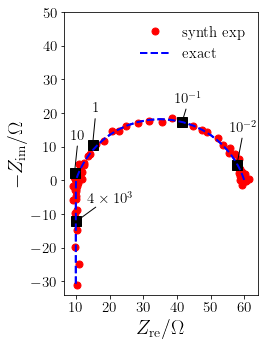

In [98]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# Nyquist plot of the impedance
plt.plot(np.real(Z_exact), -np.imag(Z_exact), '--', linewidth=2, color='blue')
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=7, color='red', label='synth exp')
plt.plot(np.real(Z_exp[20:60:10]), -np.imag(Z_exp[20:60:10]), 's', markersize=10, color='black')
plt.plot(np.real(Z_exp[76]), -np.imag(Z_exp[76]), 's', markersize=10, color='black')
plt.plot(np.real(Z_exact), -np.imag(Z_exact), '--', linewidth=2, color='blue', label='exact')

plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 70, 10))
plt.yticks(range(-30, 60, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
# label the frequency points
plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])), 
             xytext=(np.real(Z_exp[20])-2, 10-np.imag(Z_exp[20])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{-1}$', xy=(np.real(Z_exp[30]), -np.imag(Z_exp[30])), 
             xytext=(np.real(Z_exp[30])-2, 6-np.imag(Z_exp[30])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$1$', xy=(np.real(Z_exp[40]), -np.imag(Z_exp[40])), 
             xytext=(np.real(Z_exp[40]), 10-np.imag(Z_exp[40])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10$', xy=(np.real(Z_exp[50]), -np.imag(Z_exp[50])), 
             xytext=(np.real(Z_exp[50])-1, 10-np.imag(Z_exp[50])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$4\times10^3$', xy=(np.real(Z_exp[76]), -np.imag(Z_exp[76])), 
             xytext=(np.real(Z_exp[76])+3, 6-np.imag(Z_exp[76])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))

fig = plt.gcf()

fig.set_size_inches(8.4136, 5.2)
plt.show()

## 2)  The Fundamental Concepts of fGP-DRT Model
The core idea:

$$\begin{pmatrix}
\mathbf{x} \\
\mathbf Z
\end{pmatrix}
\sim \mathcal{N}\left(\mathbf 0, \begin{pmatrix}
\mathbf {\Gamma} & \mathbf {\Gamma}A^{\top} \\
A\mathbf{\Gamma}& A\mathbf {\Gamma}A^{\top}+\sigma _{n}^{2}\mathbf{I} 
\end{pmatrix}\right)$$

where
<ol> 
  <li>the array of impedance data $\mathbf Z$ is arranged as $$\mathbf Z =\begin{pmatrix} 
      \mathbf Z_{\rm re} \\
      \mathbf Z_{\rm im}
      \end{pmatrix} $$ </li>
  <p>($\mathbf Z_{\rm re}$ and $\mathbf Z_{\rm im}$ are the real and imaginary components, respectively, of the data array).</p>
    
<li>$\mathbf x$ is the value of $\gamma\left( \log \tau \right)$ at the given $\log \tau$ collocation points.</li>

### We compute the condition distribution $\mathbf{x}|\mathbf{Z}$ as follows
$$\begin{equation}
   \mathbf{x}|\mathbf{Z}\sim \mathcal{N}(\boldsymbol{\mu}_{\text{x}},\boldsymbol{\Sigma}_{\text{x}})
\end{equation}$$

where
$$\boldsymbol{\mu}_{\text{x}} = \boldsymbol{\Gamma} A^{\top}\left( A\boldsymbol{\Gamma}A^{\top} +\sigma_{n}^{2}\mathbf{I} \right )^{-1}\mathbf{Z}$$



$$\boldsymbol{\Sigma}_{\text{x}} = \boldsymbol{\Gamma} - \boldsymbol{\Gamma} A^{\top}\left (\mathbf{A} \boldsymbol{\Gamma} A^{\top} + \sigma_{n}^{2}\mathbf{I} \right )^{-1} A\boldsymbol{\Gamma} $$

### Positivity Constraint
The current GP-DRT model does not pose any constraint on $\mathbf{x}$. However, it is straightforward to impose a constraint on $\mathbf{x}|\mathbf{Z}$ by taking that $\mathbf{x}|\mathbf{Z}$ is a truncated multinormal distribution bound by zero from below, i.e., 

$$\begin{equation}
   \mathbf{x}|\mathbf{Z} = \mathbf{Z}_{\rm exp} \sim \mathcal{TN}(\boldsymbol{\mu}_{\text{x}},\boldsymbol{\Sigma}_{\text{x}}, 0, \infty)
\end{equation}$$

### 2.1) Build matrix $A$ and $\boldsymbol{\Gamma}$
$$ A = \begin{pmatrix} 
	\mathbf{0} & \mathbf{1} & \mathbf{A}_{\rm re} \\
	2\pi\,\textbf{f} & \mathbf{0} & \mathbf{A}_{\rm im}\\
	\end{pmatrix}$$

where $\mathbf 1 \in \mathbb R^{N_f\times 1}$


$$\mathbf \Gamma := \begin{pmatrix}
\mathbf \sigma_L^2 & 0 & 0 \\
0 & \mathbf \sigma_R^2 & 0\\
0 & 0 & \mathbf K
\end{pmatrix}$$

### The matrices $\mathbf{A}_{\rm re}$, $\mathbf{A}_{\rm im}$ and $A$

In [99]:
# compute A_re and A_im
A_re = finite_GP_DRT.compute_A_re(freq_vec, tau_vec)
A_im = finite_GP_DRT.compute_A_im(freq_vec, tau_vec)

# matrix A
A = np.zeros((2*N_freqs, N_taus+2))

# real part
A[:N_freqs, 1] = 1.0 
A[:N_freqs, 2:] = A_re

# imaginary part
A[N_freqs:, 0] = 2*pi*freq_vec*1E-4 # above note normalization by 1E-4
A[N_freqs:, 2:] = A_im

### 2.2) Selection of the optimal hyperparameters of the unconstrained GP-DRT model by minimizing the negative marginal log-likelihood (NMLL)

The values of the hyperparameter vector $\boldsymbol{\theta}$ were obtained by maximizing the experimental evidence, i.e., by maximizing the probability $p(\mathbf{Z} = \mathbf{Z}_{\rm exp}|\mathbf{x}, \boldsymbol \theta)$   of the experiment under no constraint on $\mathbf{x}$.

$$
\log\left(\mathbf{Z} = \mathbf{Z}_{\rm exp}|\mathbf x, \boldsymbol\theta\right) = - \frac{1}{2} \mathbf{Z}_{\rm exp}^\top \mathbf (A\boldsymbol{\Gamma}A^{\top} + \sigma_{n}^{2}\mathbf{I})^{-1}\mathbf{Z}_{\rm exp} -\frac{1}{2} \log(|A\boldsymbol{\Gamma}A^{\top} + \sigma_{n}^{2}\mathbf{I}|) - \frac{N+2}{2} \log \left( 2\pi\right)
$$
In the actual implementation
$$
L(\boldsymbol{\theta}) = -\log\left(\mathbf{Z} = \mathbf{Z}_{\rm exp}|\mathbf x, \boldsymbol\theta\right)-\frac{N+2}{2} \log \left( 2\pi\right)
$$

The above minimization problem is solved using the `optimize` function from `scipy`.

#### 2.2.1) Initialization of the parameters for the NMLL minimization

In [100]:
sigma_n = sigma_n_exp
sigma_L = 1.0
sigma_R = 1.0
sigma_f = 0.5
ell = 1.0

theta_0 = np.array([sigma_n, sigma_L, sigma_R, sigma_f, ell])

#### 2.2.2) NMLL optimization

In [101]:
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('{0:.7f}  {1:.7f}  {2:.7f}  {3:.7f}  {4:.7f}'.format(theta[0], theta[1], theta[2], theta[3], theta[4]))

print('sigma_n,   sigma_L,   sigma_R,   sigma_f,   ell')

# minimize the NMLL L(\theta) w.r.t sigma_n, sigma_R, sigma_f, and ell
res = minimize(finite_GP_DRT.NMLL_L_fct, theta_0, args=(A, Z_exp_re_im, N_freqs, log_tau_vec), method='Powell', \
                callback=print_results, options={'disp': True})

# collect the optimized parameters
sigma_n, sigma_L, sigma_R, sigma_f, ell = res.x

sigma_n,   sigma_L,   sigma_R,   sigma_f,   ell
6.0598275  5.1259134  12.9224156  5.8695373  1.7316928
0.5329702  4.9342855  10.2264220  7.5367733  1.5256769
0.5316809  4.9316841  10.2435457  6.3397050  1.5264311
0.5314689  4.9321916  10.2403401  5.9733422  1.4348724
0.5314210  4.9324664  10.2388469  5.8280182  1.3909688
Optimization terminated successfully.
         Current function value: 23.952959
         Iterations: 5
         Function evaluations: 319


### 2.3) Definition of the covariance matrix $\mathbf K$ with the optimized $\boldsymbol \theta$

In [102]:
# compute the matrix K
K = finite_GP_DRT.compute_K(log_tau_vec, sigma_f, ell)

### 2.4) Building the augmented covariance matrix  $\boldsymbol{\Gamma}$

$$\mathbf \Gamma := \begin{pmatrix}
\mathbf \sigma_L^2 & 0 & 0\\
0 & \mathbf \sigma_R^2 & 0\\
0 & 0 & \mathbf K
\end{pmatrix}$$

In [103]:
# compute the matrix Gamma
Gamma = np.zeros((N_taus+2, N_taus+2))
Gamma[0,0] = sigma_L**2
Gamma[1,1] = sigma_R**2
Gamma[2:, 2:] = K

### 2.5) Definition of $\mathbf \Psi$ and $\mathbf \Xi$ as

$$\mathbf \Psi = \mathbf A \mathbf \Gamma \mathbf A^\top + \sigma_n^2 \mathbf I$$ 
and 

$$\mathbf \Xi = \mathbf \Gamma \mathbf A^\top$$

In [104]:
# put together the matrix Gamma
Psi = A@(Gamma@A.T)+(sigma_n**2)*np.eye(2*N_freqs)
Psi = 0.5*(Psi + Psi.T) # symmetrize
Xi = Gamma@A.T

### 2.6) Factorization of the matrices and solving of the unconstrained problem
We are computing
$$
\mathbf x|\mathbf Z=Z_{\rm exp}\sim \mathcal N\left( \boldsymbol \mu_{x|Z}, \boldsymbol \Sigma_{x|Z} \right)
$$

using 
$$
\begin{align}
\boldsymbol \mu_{x|Z} &= \mathbf \Xi \mathbf \Psi^{-1}\mathbf Z_{\rm exp} \\
\boldsymbol \Sigma_{x|Z} &= \mathbf \Gamma - \mathbf \Xi \mathbf \Psi^{-1} \mathbf \Xi^\top
\end{align}
$$

The key step is to do Cholesky factorization to obtain $\mathbf \Psi$.

In [105]:
# Cholesky factorization L of Psi -L is a lower-triangular matrix-
L = np.linalg.cholesky(Psi)

# solve for alpha
alpha = np.linalg.solve(L, Z_exp_re_im)
alpha = np.linalg.solve(L.T, alpha)

# obtain mu_x
mu_x_given_Z = np.dot(Xi, alpha)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_Psi = np.dot(inv_L.T, inv_L)

# estimate the covariance matrix of gamma for eq (21b)
Sigma_x_given_Z = Gamma - Xi@(inv_Psi@Xi.T)

# useful definition for plots
R_inf_unc = mu_x_given_Z[0]
cov_R_inf_unc = Sigma_x_given_Z[0, 0]

gamma_GP_unc = mu_x_given_Z[2:]
Sigma_GP_unc = Sigma_x_given_Z[2:, 2:]

### 2.7) Plot of the unconstrained DRT

### Figure 1 (b) of SI

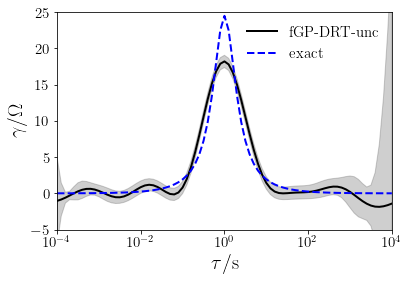

In [106]:
# plot the DRT and its confidence region
plt.semilogx(tau_vec, gamma_GP_unc, linewidth=2, color='black', label='fGP-DRT-unc')
plt.fill_between(tau_vec, gamma_GP_unc-3*np.diag(Sigma_GP_unc), gamma_GP_unc+3*np.diag(Sigma_GP_unc), 
                 color='0.25', alpha=0.25)
plt.semilogx(tau_vec, gamma_fct, '--', linewidth=2, color='blue', label='exact')

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4, 1E4, -5 ,25])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$\tau/{\rm s}$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
fig.set_size_inches(6.472, 4)

plt.show()

### 2.8)  Sample of the DRT under positivity constraint

We now sample
$$
\mathbf x|\mathbf Z=Z_{\rm exp}\sim {\mathcal TN}\left( \boldsymbol \mu_{x|Z}, \boldsymbol \Sigma_{x|Z}, 0, \infty \right)
$$

In [107]:
# inputs to the Hamilton Monte-Carlo sampler
# F*X+g >0
F = np.eye(N_taus+2) 
g = np.zeros(N_taus+2) 
# covariance & mean
M = Sigma_x_given_Z + 1E-8*np.eye(N_taus+2)
mu_r = mu_x_given_Z
# initial val
initial_x_given_Z = np.abs(mu_x_given_Z)
samples_raw = finite_GP_DRT.generate_tmg(F, g, M, mu_r, initial_x_given_Z, cov=True, L=10000)

Current sample number 1000 / 10000
Current sample number 2000 / 10000
Current sample number 3000 / 10000
Current sample number 4000 / 10000
Current sample number 5000 / 10000
Current sample number 6000 / 10000
Current sample number 7000 / 10000
Current sample number 8000 / 10000
Current sample number 9000 / 10000
Current sample number 10000 / 10000


In [108]:
# postprocessing
samples = samples_raw[:,1000:] # remove burn in
samples_gamma = samples[2:,:] # slice out only samples of gamma
samples_Z_re_im = A@samples # samples of Z_re_im

### 2.9)  Plot of the constrained DRT
### Figure 1 (c) of SI

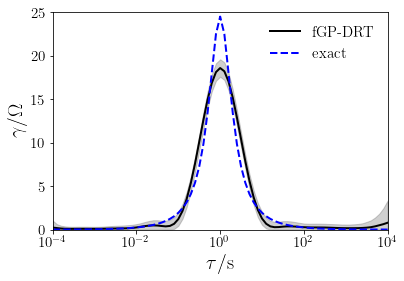

In [109]:
gamma_avg = np.average(samples_gamma,axis=1)
gamma_std = np.std(samples_gamma,axis=1)
gamma_median = np.nanmedian(samples_gamma,axis=1)
gamma_percentile_0dot1 = np.percentile(samples_gamma, 1, axis=1)
gamma_percentile_0dot5 = np.percentile(samples_gamma, 50, axis=1)
gamma_percentile_0dot9 = np.percentile(samples_gamma, 99, axis=1)

# plot the DRT and its confidence region
plt.semilogx(tau_vec, gamma_median, linewidth=2, color='black', label='fGP-DRT')
plt.fill_between(tau_vec, gamma_percentile_0dot1, gamma_percentile_0dot9, 
                 color='0.25', alpha=0.25)
plt.semilogx(tau_vec, gamma_fct, '--', linewidth=2, color='blue', label='exact')

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4, 1E4, 0 ,25])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$\tau/{\rm s}$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
fig.set_size_inches(6.472, 4)
plt.show()

### 2.10) Plot of the constrained impedance

In [110]:
Z_re_im_avg = np.average(samples_Z_re_im,axis=1)
Z_re_im_std = np.std(samples_Z_re_im,axis=1)
Z_re_im_median = np.nanmedian(samples_Z_re_im,axis=1)
Z_re_im_percentile_0dot1 = np.percentile(samples_Z_re_im, 1, axis=1)
Z_re_im_percentile_0dot5 = np.percentile(samples_Z_re_im, 50, axis=1)
Z_re_im_percentile_0dot9 = np.percentile(samples_Z_re_im, 99, axis=1)

Z_re_median = Z_re_im_median[:N_freqs]
Z_im_median = Z_re_im_median[N_freqs:]

Z_re_percentile_0dot1 = Z_re_im_percentile_0dot1[:N_freqs]
Z_re_percentile_0dot9 = Z_re_im_percentile_0dot9[:N_freqs]
Z_im_percentile_0dot1 = Z_re_im_percentile_0dot1[N_freqs:]
Z_im_percentile_0dot9 = Z_re_im_percentile_0dot9[N_freqs:]

###  Comparison of the impedances from the constrained fGP-DRT against the exact one

### Figure 1 (d) of SI

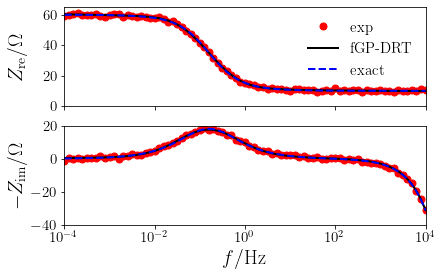

In [111]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.semilogx(freq_vec, Z_exp.real, 'o', markersize=7, color='red', label='exp')
ax1.semilogx(freq_vec, Z_re_median, linewidth=2, color='black', label='fGP-DRT')
ax1.fill_between(freq_vec, Z_re_percentile_0dot1, Z_re_percentile_0dot9, 
                 color='0.25', alpha=0.25)
ax1.semilogx(freq_vec, Z_exact.real, '--', linewidth=2, color='blue', label='exact')
ax1.set_ylabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
ax1.axis([1E-4, 1E4, 0, 65])
ax1.legend(frameon=False, fontsize = 15)
ax1.set_yticks(np.arange(0, 70, step=20)) 

ax2.semilogx(freq_vec, -Z_exp.imag, 'o', markersize=7, color='red', label='exp')
ax2.semilogx(freq_vec, -Z_im_median, linewidth=2, color='black', label='fGP-DRT')
ax2.fill_between(freq_vec, -Z_im_percentile_0dot1, -Z_im_percentile_0dot9, 
                 color='0.25', alpha=0.25)
ax2.semilogx(freq_vec, -Z_exact.imag, '--', linewidth=2, color='blue', label='exact')
ax2.set_ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
ax2.axis([1E-4, 1E4, -40, 20])


plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
fig.set_size_inches(6.472, 4)

fig.align_ylabels()

plt.show()